In [1]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random
import datetime

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

In [2]:
def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]

In [3]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

In [4]:
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

Database interaction not yet implemented. Use pickle file for dataframes instead!


### Run 30-minute simulations at a fixed windspeed and direction : ws=10, wd=90

In [5]:
igniteidx = usr.db.gdfignition.index[0]
compareidx = uuid.uuid4().hex
lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

# Generate df for the next reference ignition only to get the datetime
filetype = 'Ignition'
objectid = str(usr.db.gdfignition.loc[igniteidx, 'objectid']) + '_Ref1'
filepath = f'/home/jovyan/farsite/inputs/maria_ignite/maria_{compareidx}'
comparedatetime = usr.db.gdfignition.loc[igniteidx, 'datetime'] + datetime.timedelta(minutes=30)
description = SELECTED_FIRE_DEFAULT

gdfcompare = gpd.GeoDataFrame(index=[compareidx], data = {'filetype': filetype,
                                      'objectid': objectid,
                                      'filepath': filepath,
                                      'datetime': comparedatetime,
                                      'description': description,
                                      'geometry': None})

usr.db.gdfignition = pd.concat([usr.db.gdfignition, gdfcompare])

In [6]:
windspeed = 10
winddirection = 90

inputData = {'description': description,
             'igniteidx'  : igniteidx,
             'compareidx' : compareidx,
             'lcpidx'     : lcpidx,
             'barrieridx' : barrieridx,

             'windspeed': windspeed, 'winddirection': winddirection,
             'relhumid': 90, 'temperature': 20}

mainapi = usr.calculatePerimeters(inputData)
mainapi.run_farsite()

# Collect the simulated geometry
gdfsim = usr.db.gdfsimulation.iloc[-1]
gdfsim_geom = gdfsim['geometry']
if isinstance(gdfsim_geom, MultiPolygon):
    gdfsim_geom = calculate_max_area_geom(gdfsim_geom)
    
# Update the ignition table with the simulated info
usr.db.gdfignition.loc[compareidx, 'filepath'] = usr.db.gdfsimulation.iloc[-1]['filepath']
usr.db.gdfignition.loc[compareidx, 'geometry'] = gdfsim_geom

{'description': 'Maria2019', 'igniteidx': 'f23196b034474744bdca7df94b13e0f7', 'compareidx': '01d1542baa52432e90321685ad069613', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 16).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00001/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00001/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


In [9]:
def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)

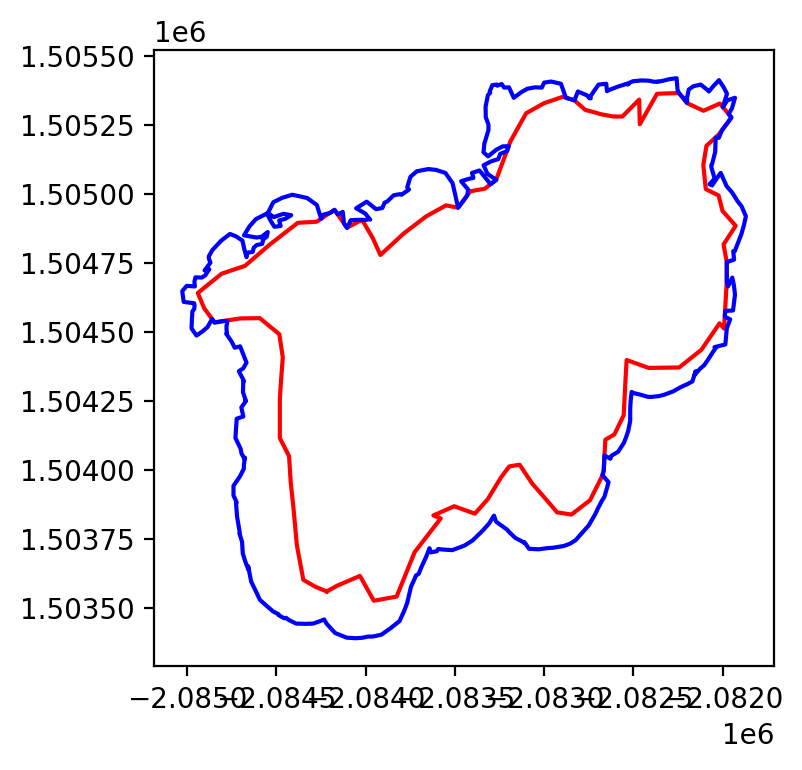

In [11]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(usr.db.gdfignition.loc[igniteidx, 'geometry'], ax=ax, color='red')
plot_geometry(usr.db.gdfignition.loc[compareidx, 'geometry'], ax=ax, color='blue')